> Examples

Refer: https://github.com/benedekrozemberczki/pytorch_geometric_temporal/tree/master/examples/recurrent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

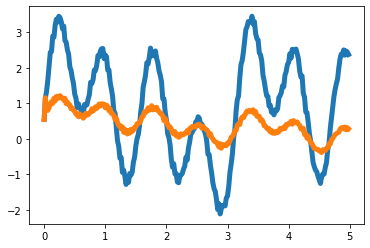

In [2]:
T = 250
t = np.arange(T)/T * 5

x = 1*np.sin(2*t)+0.3*np.random.rand(T)+0.5+np.sin(4*t)+1.5*np.sin(8*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
for i in range(2,T):
    y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.5*np.cos(0.4*t[i]) 
eps_y  = np.random.normal(size=T)*0
x = x
y = y
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1]]).tolist()

data_dict = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}

# save_data(data_dict1, './data/toy_example1.pkl')

data = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

# save_data(data1, './data/toy_example_true1.csv')

In [3]:
import itstgcn

In [4]:
loader = itstgcn.DatasetLoader(data_dict)

# GConvGRU

In [140]:
GConvGRU?

Init signature:
GConvGRU(
    in_channels: int,
    out_channels: int,
    K: int,
    normalization: str = 'sym',
    bias: bool = True,
)
Docstring:     
An implementation of the Chebyshev Graph Convolutional Gated Recurrent Unit
Cell. For details see this paper: `"Structured Sequence Modeling with Graph
Convolutional Recurrent Networks." <https://arxiv.org/abs/1612.07659>`_

Args:
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    K (int): Chebyshev filter size :math:`K`.
    normalization (str, optional): The normalization scheme for the graph
        Laplacian (default: :obj:`"sym"`):

        1. :obj:`None`: No normalization
        :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

        2. :obj:`"sym"`: Symmetric normalization
        :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
        \mathbf{D}^{-1/2}`

        3. :obj:`"rw"`: Random-walk normalization
        :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1} 

In [6]:
# from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = WikiMathsDatasetLoader()

dataset = loader.get_dataset(lags=4)

# train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [8]:
from tqdm import tqdm

model = RecurrentGCN(node_features=4, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):# 50
    _b=[]
    _d=[]
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
        _b.append(y_hat)
        mean_diff = torch.mean((y_hat-snapshot.y), dim=0)
        cost = torch.square(mean_diff)
        _d.append(cost)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


In [9]:
model.eval()
cost = 0
_a = []
_a1 = []
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
    _a1.append(cost)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.4200


In [10]:
_e = [_d[i].detach() for i in range(len(_d))]

In [11]:
_c = [_a1[i].detach() for i in range(len(_a1))]

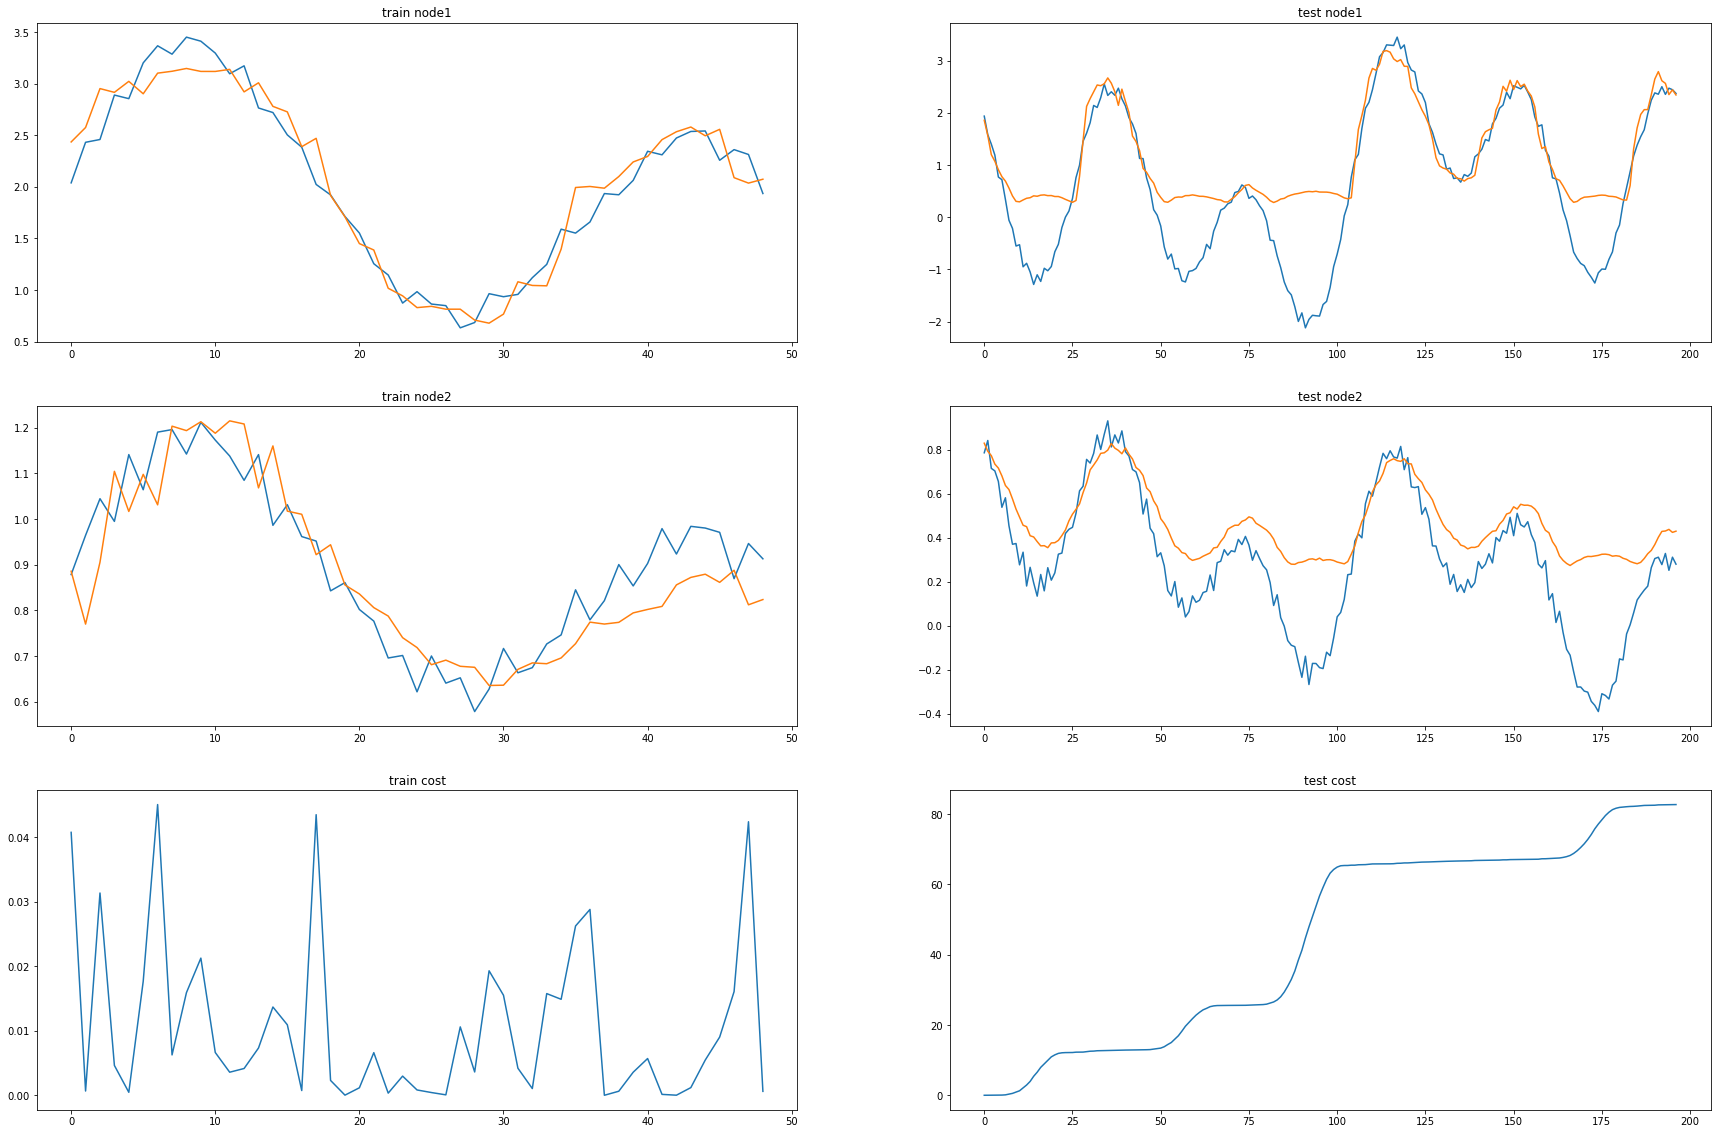

In [12]:
fig, (( ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(30,20))

ax1.set_title('train node1')
ax1.plot([train_dataset.targets[i][0] for i in range(train_dataset.snapshot_count)])
ax1.plot(torch.tensor([_b[i].detach()[0] for i in range(train_dataset.snapshot_count)]))

ax2.set_title('test node1')
ax2.plot([test_dataset.targets[i][0] for i in range(test_dataset.snapshot_count)])
ax2.plot(torch.tensor([_a[i].detach()[0] for i in range(test_dataset.snapshot_count)]))

ax3.set_title('train node2')
ax3.plot([train_dataset.targets[i][1] for i in range(train_dataset.snapshot_count)])
ax3.plot(torch.tensor([_b[i].detach()[1] for i in range(train_dataset.snapshot_count)]))


ax4.set_title('test node2')
ax4.plot([test_dataset.targets[i][1] for i in range(test_dataset.snapshot_count)])
ax4.plot(torch.tensor([_a[i].detach()[1] for i in range(test_dataset.snapshot_count)]))

ax5.set_title('train cost')
ax5.plot(_e)

ax6.set_title('test cost')
ax6.plot(_c)

# A3GCN2

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

In [14]:
# import torch
# import torch.nn.functional as F
# from torch_geometric.nn import GCNConv
# from torch_geometric_temporal.nn.recurrent import A3TGCN2

In [15]:
# # GPU support
# DEVICE = torch.device('cuda') # cuda
# shuffle=True
# batch_size = 32

In [16]:
#Dataset
#Traffic forecasting dataset based on Los Angeles Metropolitan traffic
#207 loop detectors on highways
#March 2012 - June 2012
#From the paper: Diffusion Convolutional Recurrent Neural Network

In [17]:
# from torch_geometric_temporal.dataset import METRLADatasetLoader
# loader = METRLADatasetLoader()
# dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

In [18]:
# # Visualize traffic over time
# sensor_number = 1
# hours = 24
# sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
# plt.plot(sensor_labels)

In [19]:
# # Train test split 

# from torch_geometric_temporal.signal import temporal_signal_split
# train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)


In [20]:
# # Creating Dataloaders

# train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
# train_target = np.array(train_dataset.targets) # (27399, 207, 12)
# train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
# train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
# train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
# train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [21]:
# test_input = np.array(test_dataset.features) # (, 207, 2, 12)
# test_target = np.array(test_dataset.targets) # (, 207, 12)
# test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
# test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
# test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
# test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [22]:
# # Making the model 
# class TemporalGNN(torch.nn.Module):
#     def __init__(self, node_features, periods, batch_size):
#         super(TemporalGNN, self).__init__()
#         # Attention Temporal Graph Convolutional Cell
#         self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
#         # Equals single-shot prediction
#         self.linear = torch.nn.Linear(32, periods)

#     def forward(self, x, edge_index):
#         """
#         x = Node features for T time steps
#         edge_index = Graph edge indices
#         """
#         h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
#         h = F.relu(h) 
#         h = self.linear(h)
#         return h

In [23]:
# TemporalGNN(node_features=2, periods=12, batch_size=2)

In [24]:
# # Create model and optimizers
# model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size).to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss_fn = torch.nn.MSELoss()


In [25]:
# print('Net\'s state_dict:')
# total_param = 0
# for param_tensor in model.state_dict():
#     print(param_tensor, '\t', model.state_dict()[param_tensor].size())
#     total_param += np.prod(model.state_dict()[param_tensor].size())
# print('Net\'s total params:', total_param)
# #--------------------------------------------------
# print('Optimizer\'s state_dict:')  # If you notice here the Attention is a trainable parameter
# for var_name in optimizer.state_dict():
#     print(var_name, '\t', optimizer.state_dict()[var_name])


In [26]:
# # Loading the graph once because it's a static graph

# for snapshot in train_dataset:
#     static_edge_index = snapshot.edge_index.to(DEVICE)
#     break;


In [27]:
# # Training the model 
# model.train()

# for epoch in range(3): # 30
#     step = 0
#     loss_list = []
#     for encoder_inputs, labels in train_loader:
#         y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
#         loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         step= step+ 1
#         loss_list.append(loss.item())
#         if step % 100 == 0 :
#             print(sum(loss_list)/len(loss_list))
#     print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

In [28]:
## Evaluation

#- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
#- The model always gets one hour and needs to predict the next hour

In [29]:
# model.eval()
# step = 0
# # Store for analysis
# total_loss = []
# for encoder_inputs, labels in test_loader:
#     # Get model predictions
#     y_hat = model(encoder_inputs, static_edge_index)
#     # Mean squared error
#     loss = loss_fn(y_hat, labels)
#     total_loss.append(loss.item())
#     # Store for analysis below
#     #test_labels.append(labels)
#     #predictions.append(y_hat)

In [30]:
# print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

In [31]:
## Visualization

# - The further away the point in time is, the worse the predictions get
# - Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [32]:
# sensor = 123
# timestep = 11 
# preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
# labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
# print("Data points:,", preds.shape)

In [33]:
# plt.figure(figsize=(20,5))
# sns.lineplot(data=preds, label="pred")
# sns.lineplot(data=labs, label="true")

# A3GCN(cuda 문제)

In [34]:
# try:
#     from tqdm import tqdm
# except ImportError:
#     def tqdm(iterable):
#         return iterable

In [35]:
# # import torch
# # import torch.nn.functional as F
# from torch_geometric_temporal.nn.recurrent import A3TGCN

In [36]:
# # from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
# from torch_geometric_temporal.signal import temporal_signal_split


In [37]:
# # loader = ChickenpoxDatasetLoader()

# dataset = loader.get_dataset(lags=4)

# train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)


In [38]:
# class RecurrentGCN(torch.nn.Module):
#     def __init__(self, node_features, periods):
#         super(RecurrentGCN, self).__init__()
#         self.recurrent = A3TGCN(node_features, 32, periods)
#         self.linear = torch.nn.Linear(32, 1)

#     def forward(self, x, edge_index, edge_weight):
#         h = self.recurrent(x.to("cuda:0").view(x.shape[0], 1, x.shape[1]), edge_index, edge_weight)
#         h = F.relu(h)
#         h = self.linear(h)
#         return h

In [39]:
# model = RecurrentGCN(node_features = 4, periods = 4)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# model.train()

# for epoch in tqdm(range(50)):
#     cost = 0
#     for time, snapshot in enumerate(train_dataset):
#         y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
#         cost = cost + torch.mean((y_hat-snapshot.y)**2)
#     cost = cost / (time+1)
#     cost.backward()
#     optimizer.step()
#     optimizer.zero_grad()

In [40]:
# model.eval()
# cost = 0
# for time, snapshot in enumerate(test_dataset):
#     y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
#     cost = cost + torch.mean((y_hat-snapshot.y)**2)
# cost = cost / (time+1)
# cost = cost.item()
# print("MSE: {:.4f}".format(cost))

# AGCRN

In [141]:
AGCRN?

Init signature:
AGCRN(
    number_of_nodes: int,
    in_channels: int,
    out_channels: int,
    K: int,
    embedding_dimensions: int,
)
Docstring:     
An implementation of the Adaptive Graph Convolutional Recurrent Unit.
For details see: `"Adaptive Graph Convolutional Recurrent Network
for Traffic Forecasting" <https://arxiv.org/abs/2007.02842>`_
Args:
    number_of_nodes (int): Number of vertices.
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    K (int): Filter size :math:`K`.
    embedding_dimensions (int): Number of node embedding dimensions.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torch_geometric_temporal/nn/recurrent/agcrn.py
Type:           type
Subclasses:     


In [42]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [43]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader1 = ChickenpoxDatasetLoader()

dataset = loader1.get_dataset(lags=8)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [44]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features,number_of_nodes):
        super(RecurrentGCN, self).__init__()
        self.recurrent = AGCRN(number_of_nodes = 20,
                              in_channels = node_features,
                              out_channels = 2,
                              K = 2,
                              embedding_dimensions = 4)
        self.linear = torch.nn.Linear(2, 1)

    def forward(self, x, e, h):
        h_0 = self.recurrent(x, e, h)
        y = F.relu(h_0)
        y = self.linear(y)
        return y, h_0

In [45]:
model = RecurrentGCN(node_features = 8,number_of_nodes=20)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

e = torch.empty(20, 4)

torch.nn.init.xavier_uniform_(e)

for epoch in tqdm(range(200)):
    cost = 0
    h = None
    _b=[]
    _d=[]
    for time, snapshot in enumerate(train_dataset):
        x = snapshot.x.view(1, 20, 8)
        y_hat, h = model(x, e, h)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
        _b.append(y_hat)
        _d.append(cost)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:41<00:00,  4.83it/s]


In [46]:
model.eval()
cost = 0
_a=[]
_a1=[]
for time, snapshot in enumerate(test_dataset):
    x = snapshot.x.view(1, 20, 8)
    y_hat, h = model(x, e, h)
    y_hat = y_hat.reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
    _a1.append(cost)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.1103


In [47]:
_e = [_d[i].detach() for i in range(len(_d))]

In [48]:
_c = [_a1[i].detach() for i in range(len(_a1))]

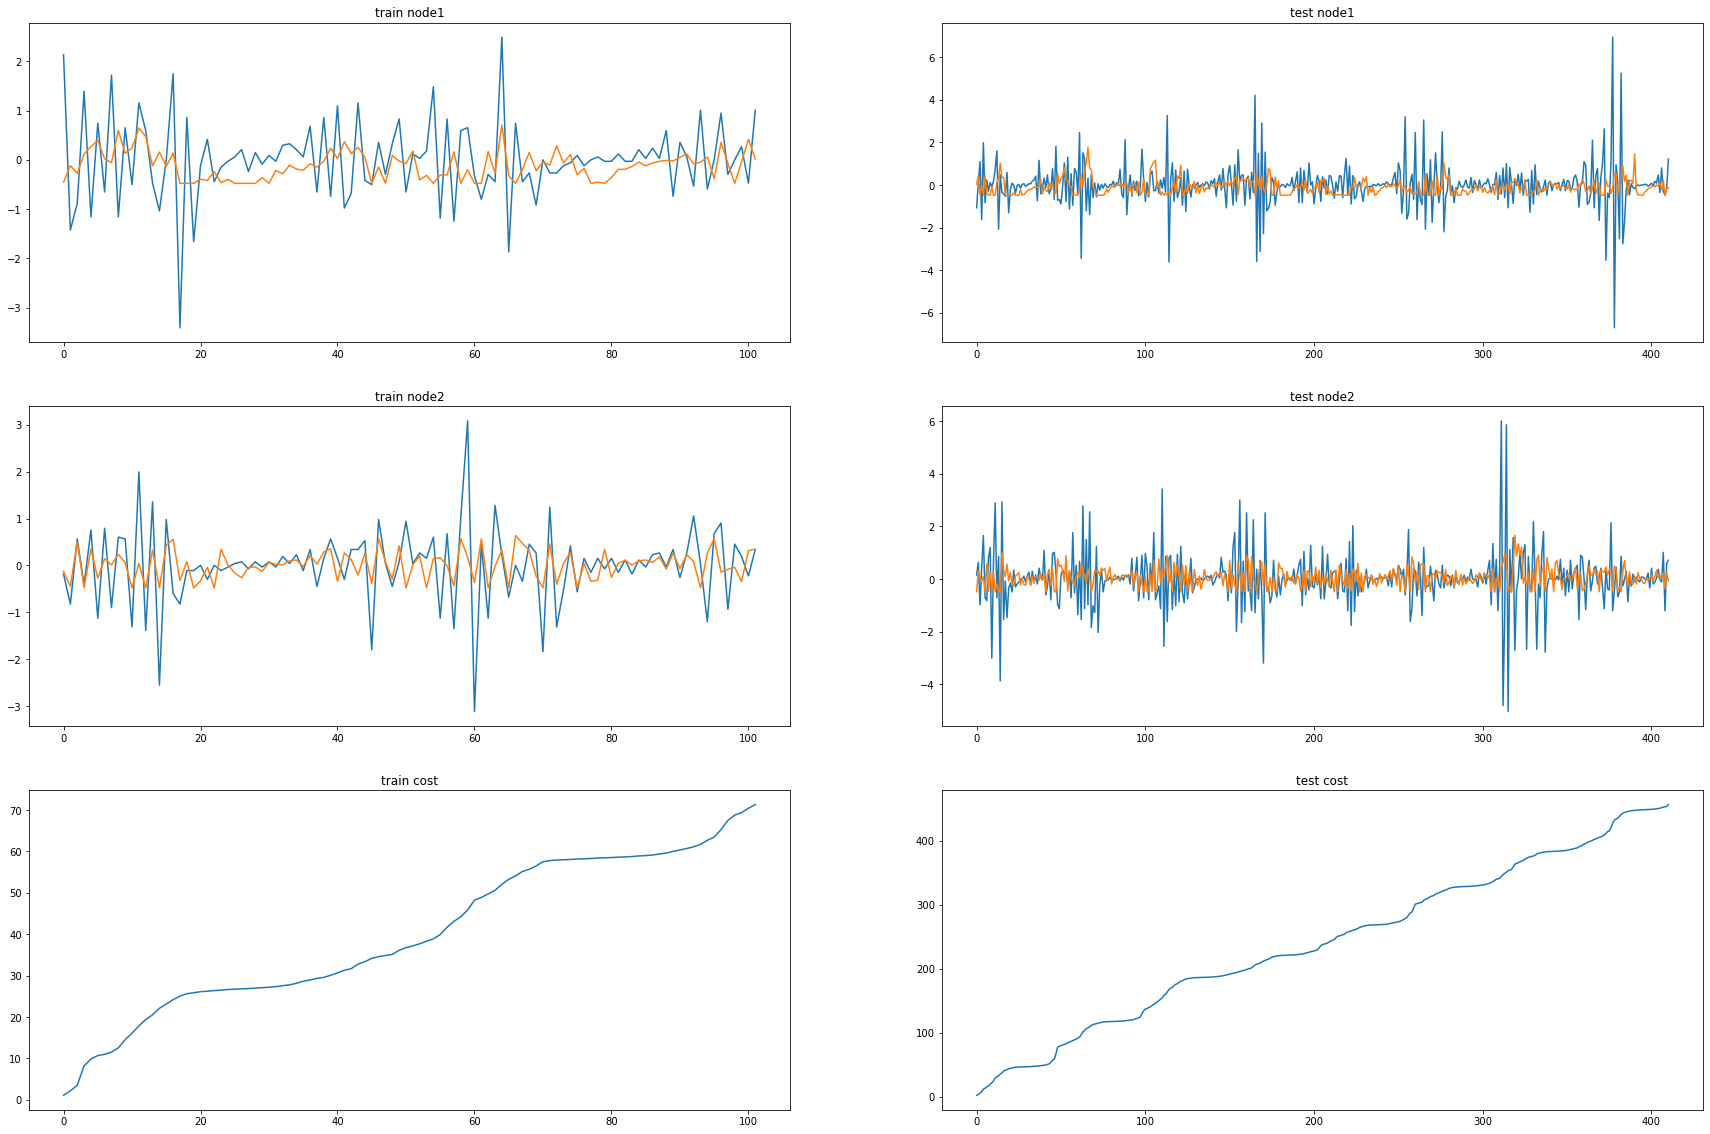

In [49]:
fig, (( ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(30,20))

ax1.set_title('train node1')
ax1.plot([train_dataset.targets[i][0] for i in range(train_dataset.snapshot_count)])
ax1.plot(torch.tensor([_b[i].detach()[0] for i in range(train_dataset.snapshot_count)]))

ax2.set_title('test node1')
ax2.plot([test_dataset.targets[i][0] for i in range(test_dataset.snapshot_count)])
ax2.plot(torch.tensor([_a[i].detach()[0] for i in range(test_dataset.snapshot_count)]))

ax3.set_title('train node2')
ax3.plot([train_dataset.targets[i][1] for i in range(train_dataset.snapshot_count)])
ax3.plot(torch.tensor([_b[i].detach()[1] for i in range(train_dataset.snapshot_count)]))


ax4.set_title('test node2')
ax4.plot([test_dataset.targets[i][1] for i in range(test_dataset.snapshot_count)])
ax4.plot(torch.tensor([_a[i].detach()[1] for i in range(test_dataset.snapshot_count)]))

ax5.set_title('train cost')
ax5.plot(_e)

ax6.set_title('test cost')
ax6.plot(_c)

# DCRNN

In [142]:
DCRNN?

Init signature: DCRNN(in_channels: int, out_channels: int, K: int, bias: bool = True)
Docstring:     
An implementation of the Diffusion Convolutional Gated Recurrent Unit.
For details see: `"Diffusion Convolutional Recurrent Neural Network:
Data-Driven Traffic Forecasting" <https://arxiv.org/abs/1707.01926>`_

Args:
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    K (int): Filter size :math:`K`.
    bias (bool, optional): If set to :obj:`False`, the layer
        will not learn an additive bias (default :obj:`True`)
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torch_geometric_temporal/nn/recurrent/dcrnn.py
Type:           type
Subclasses:     


In [51]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [52]:
# import torch
# import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [53]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [54]:
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    _b=[]
    _d=[]
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
        _b.append(y_hat)
        _d.append(cost)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:21<00:00,  9.44it/s]


In [55]:
model.eval()
cost = 0
_a = []
_a1=[]
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
    _a1.append(cost)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.1927


In [56]:
_e = [_d[i].detach() for i in range(len(_d))]

In [57]:
_c = [_a1[i].detach() for i in range(len(_a1))]

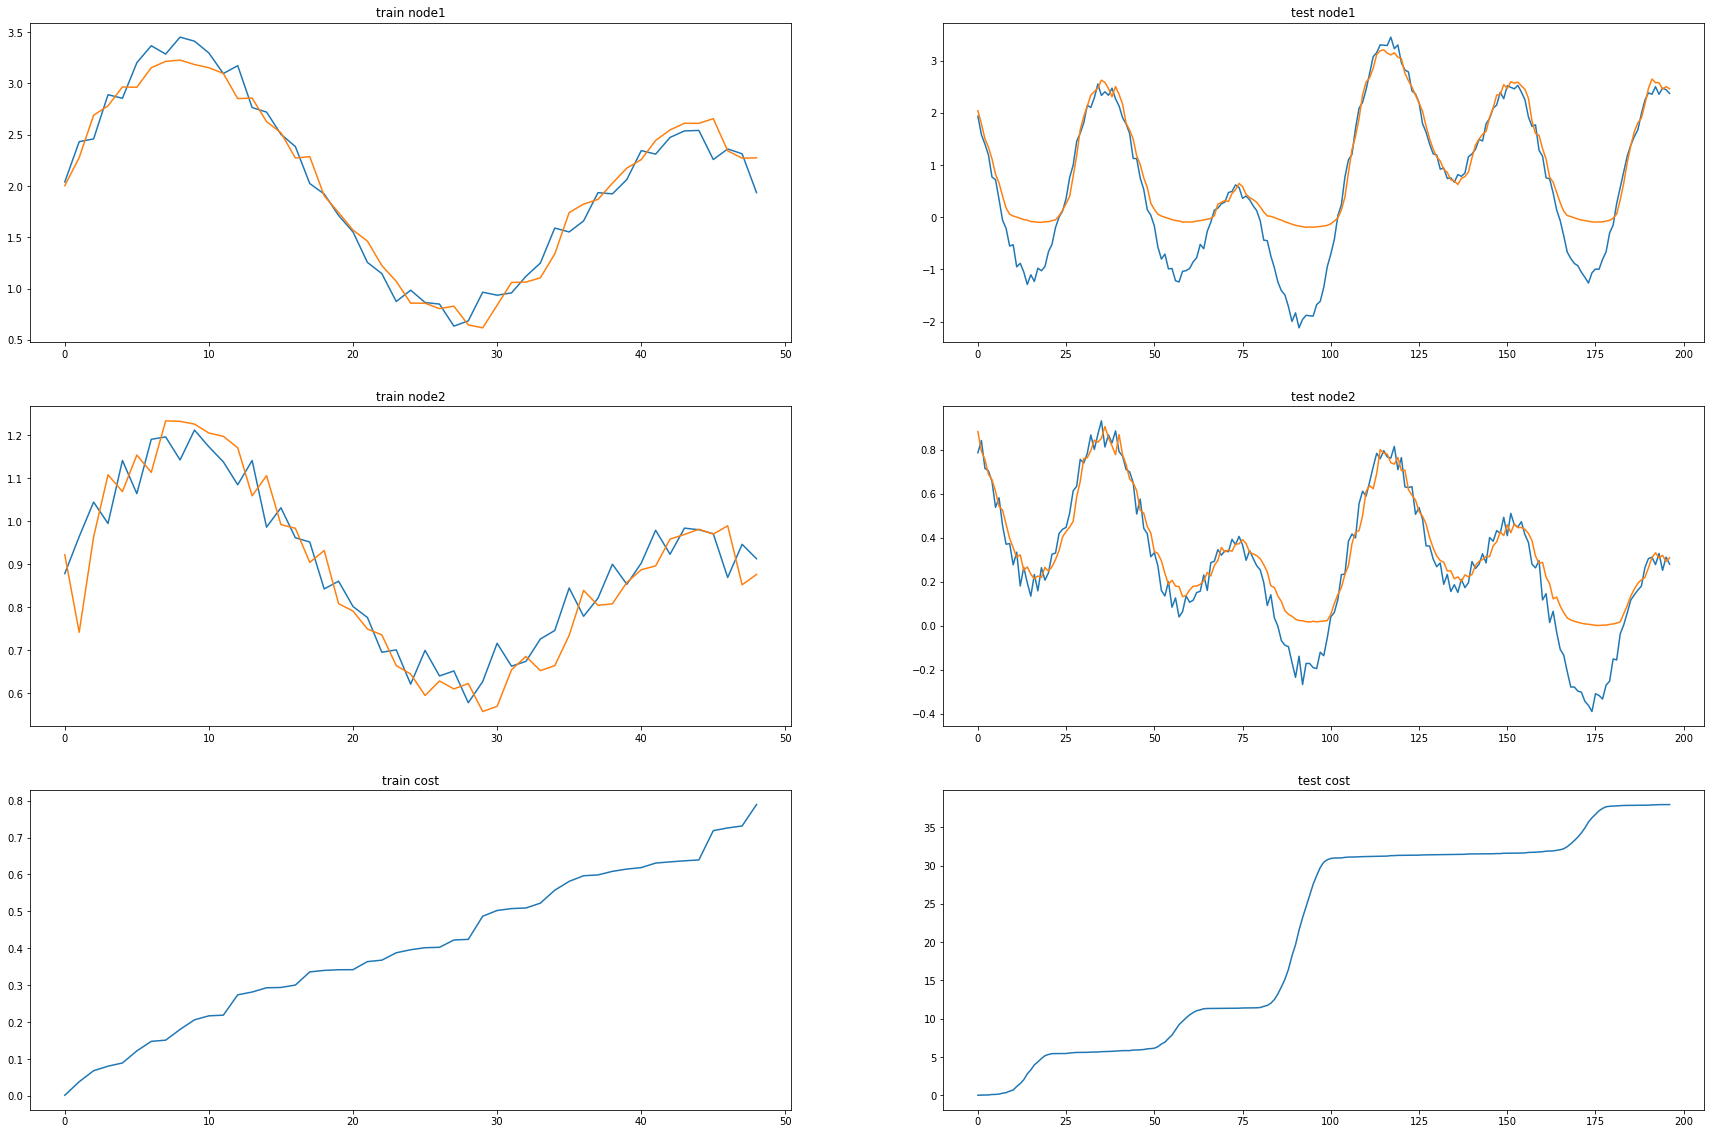

In [58]:
fig, (( ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(30,20))

ax1.set_title('train node1')
ax1.plot([train_dataset.targets[i][0] for i in range(train_dataset.snapshot_count)])
ax1.plot(torch.tensor([_b[i].detach()[0] for i in range(train_dataset.snapshot_count)]))

ax2.set_title('test node1')
ax2.plot([test_dataset.targets[i][0] for i in range(test_dataset.snapshot_count)])
ax2.plot(torch.tensor([_a[i].detach()[0] for i in range(test_dataset.snapshot_count)]))

ax3.set_title('train node2')
ax3.plot([train_dataset.targets[i][1] for i in range(train_dataset.snapshot_count)])
ax3.plot(torch.tensor([_b[i].detach()[1] for i in range(train_dataset.snapshot_count)]))


ax4.set_title('test node2')
ax4.plot([test_dataset.targets[i][1] for i in range(test_dataset.snapshot_count)])
ax4.plot(torch.tensor([_a[i].detach()[1] for i in range(test_dataset.snapshot_count)]))

ax5.set_title('train cost')
ax5.plot(_e)

ax6.set_title('test cost')
ax6.plot(_c)

# DYGRENCODER

In [143]:
DyGrEncoder?

Init signature:
DyGrEncoder(
    conv_out_channels: int,
    conv_num_layers: int,
    conv_aggr: str,
    lstm_out_channels: int,
    lstm_num_layers: int,
)
Docstring:     
An implementation of the integrated Gated Graph Convolution Long Short
Term Memory Layer. For details see this paper: `"Predictive Temporal Embedding
of Dynamic Graphs." <https://ieeexplore.ieee.org/document/9073186>`_

Args:
    conv_out_channels (int): Number of output channels for the GGCN.
    conv_num_layers (int): Number of Gated Graph Convolutions.
    conv_aggr (str): Aggregation scheme to use
        (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
    lstm_out_channels (int): Number of LSTM channels.
    lstm_num_layers (int): Number of neurons in LSTM.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torch_geometric_temporal/nn/recurrent/dygrae.py
Type:           type
Subclasses:     


In [60]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [61]:
# import torch
# import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DyGrEncoder

# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [62]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DyGrEncoder(conv_out_channels=4, conv_num_layers=1, conv_aggr="mean", lstm_out_channels=32, lstm_num_layers=1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h, h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h)
        h = self.linear(h)
        return h, h_0, c_0

In [63]:
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    h, c = None, None
    _b=[]
    _d=[]
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
        _b.append(y_hat)
        _d.append(cost)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:17<00:00, 11.24it/s]


In [64]:
model.eval()
cost = 0
h, c = None, None
_a=[]
_a1=[]
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    y_hat = y_hat.reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
    _a1.append(cost)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.3797


In [65]:
_e = [_d[i].detach() for i in range(len(_d))]

In [66]:
_c = [_a1[i].detach() for i in range(len(_a1))]

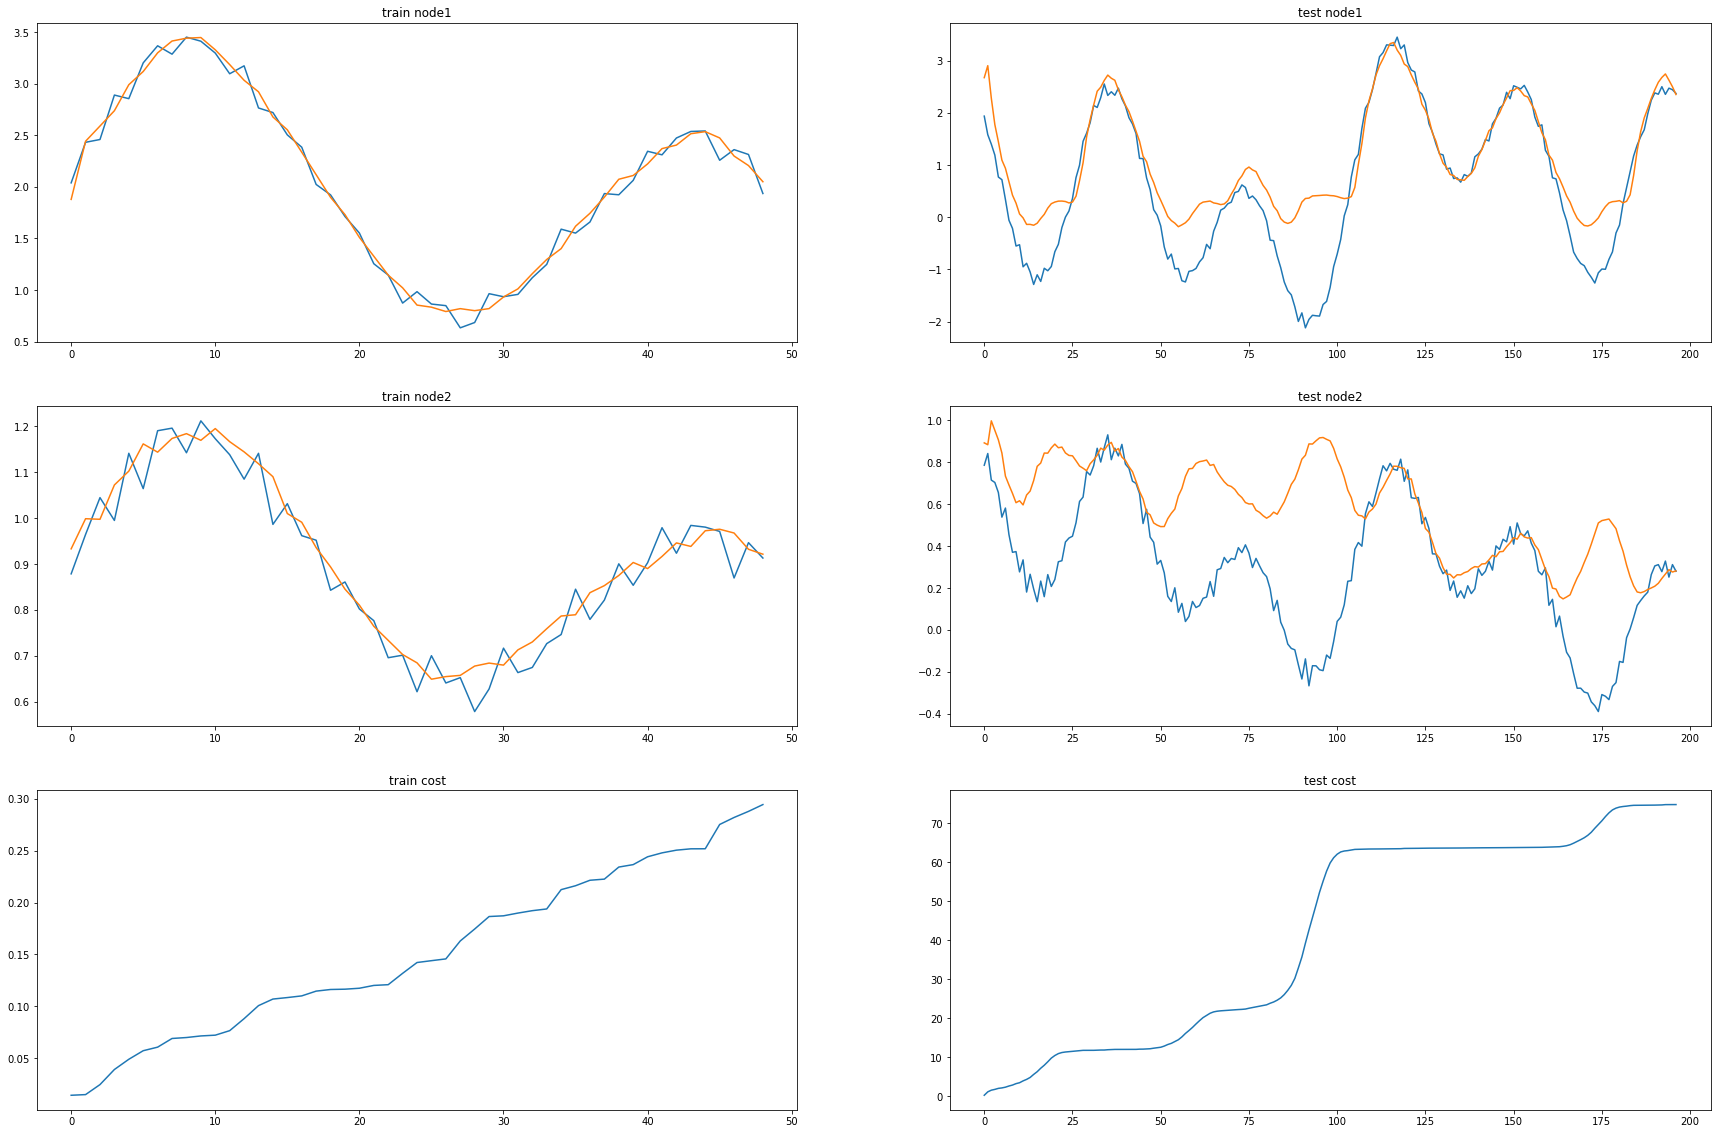

In [67]:
fig, (( ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(30,20))

ax1.set_title('train node1')
ax1.plot([train_dataset.targets[i][0] for i in range(train_dataset.snapshot_count)])
ax1.plot(torch.tensor([_b[i].detach()[0] for i in range(train_dataset.snapshot_count)]))

ax2.set_title('test node1')
ax2.plot([test_dataset.targets[i][0] for i in range(test_dataset.snapshot_count)])
ax2.plot(torch.tensor([_a[i].detach()[0] for i in range(test_dataset.snapshot_count)]))

ax3.set_title('train node2')
ax3.plot([train_dataset.targets[i][1] for i in range(train_dataset.snapshot_count)])
ax3.plot(torch.tensor([_b[i].detach()[1] for i in range(train_dataset.snapshot_count)]))


ax4.set_title('test node2')
ax4.plot([test_dataset.targets[i][1] for i in range(test_dataset.snapshot_count)])
ax4.plot(torch.tensor([_a[i].detach()[1] for i in range(test_dataset.snapshot_count)]))

ax5.set_title('train cost')
ax5.plot(_e)

ax6.set_title('test cost')
ax6.plot(_c)

# EvolveGCNH

In [144]:
EvolveGCNH?

Init signature:
EvolveGCNH(
    num_of_nodes: int,
    in_channels: int,
    improved: bool = False,
    cached: bool = False,
    normalize: bool = True,
    add_self_loops: bool = True,
)
Docstring:     
An implementation of the Evolving Graph Convolutional Hidden Layer.
For details see this paper: `"EvolveGCN: Evolving Graph Convolutional
Networks for Dynamic Graph." <https://arxiv.org/abs/1902.10191>`_

Args:
    num_of_nodes (int): Number of vertices.
    in_channels (int): Number of filters.
    improved (bool, optional): If set to :obj:`True`, the layer computes
        :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
        (default: :obj:`False`)
    cached (bool, optional): If set to :obj:`True`, the layer will cache
        the computation of :math:`\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2}` on first execution, and will use the
        cached version for further executions.
        This parameter should only be set to :obj:`True` 

In [69]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [70]:
# import torch
# import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader1 = ChickenpoxDatasetLoader()

dataset = loader1.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [71]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, num_of_nodes, in_channels):
        super(RecurrentGCN, self).__init__()
        self.recurrent = EvolveGCNH(num_of_nodes, in_channels)
        self.linear = torch.nn.Linear(in_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [72]:
model = RecurrentGCN(num_of_nodes = 20,in_channels = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    _b=[]
    _d=[]
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
        _b.append(y_hat)
        _d.append(cost)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:33<00:00,  5.96it/s]


In [73]:
model.eval()
cost = 0
_a=[]
_a1=[]
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
    _a1.append(cost)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.9995


In [74]:
_e = [_d[i].detach() for i in range(len(_d))]

In [75]:
_c = [_a1[i].detach() for i in range(len(_a1))]

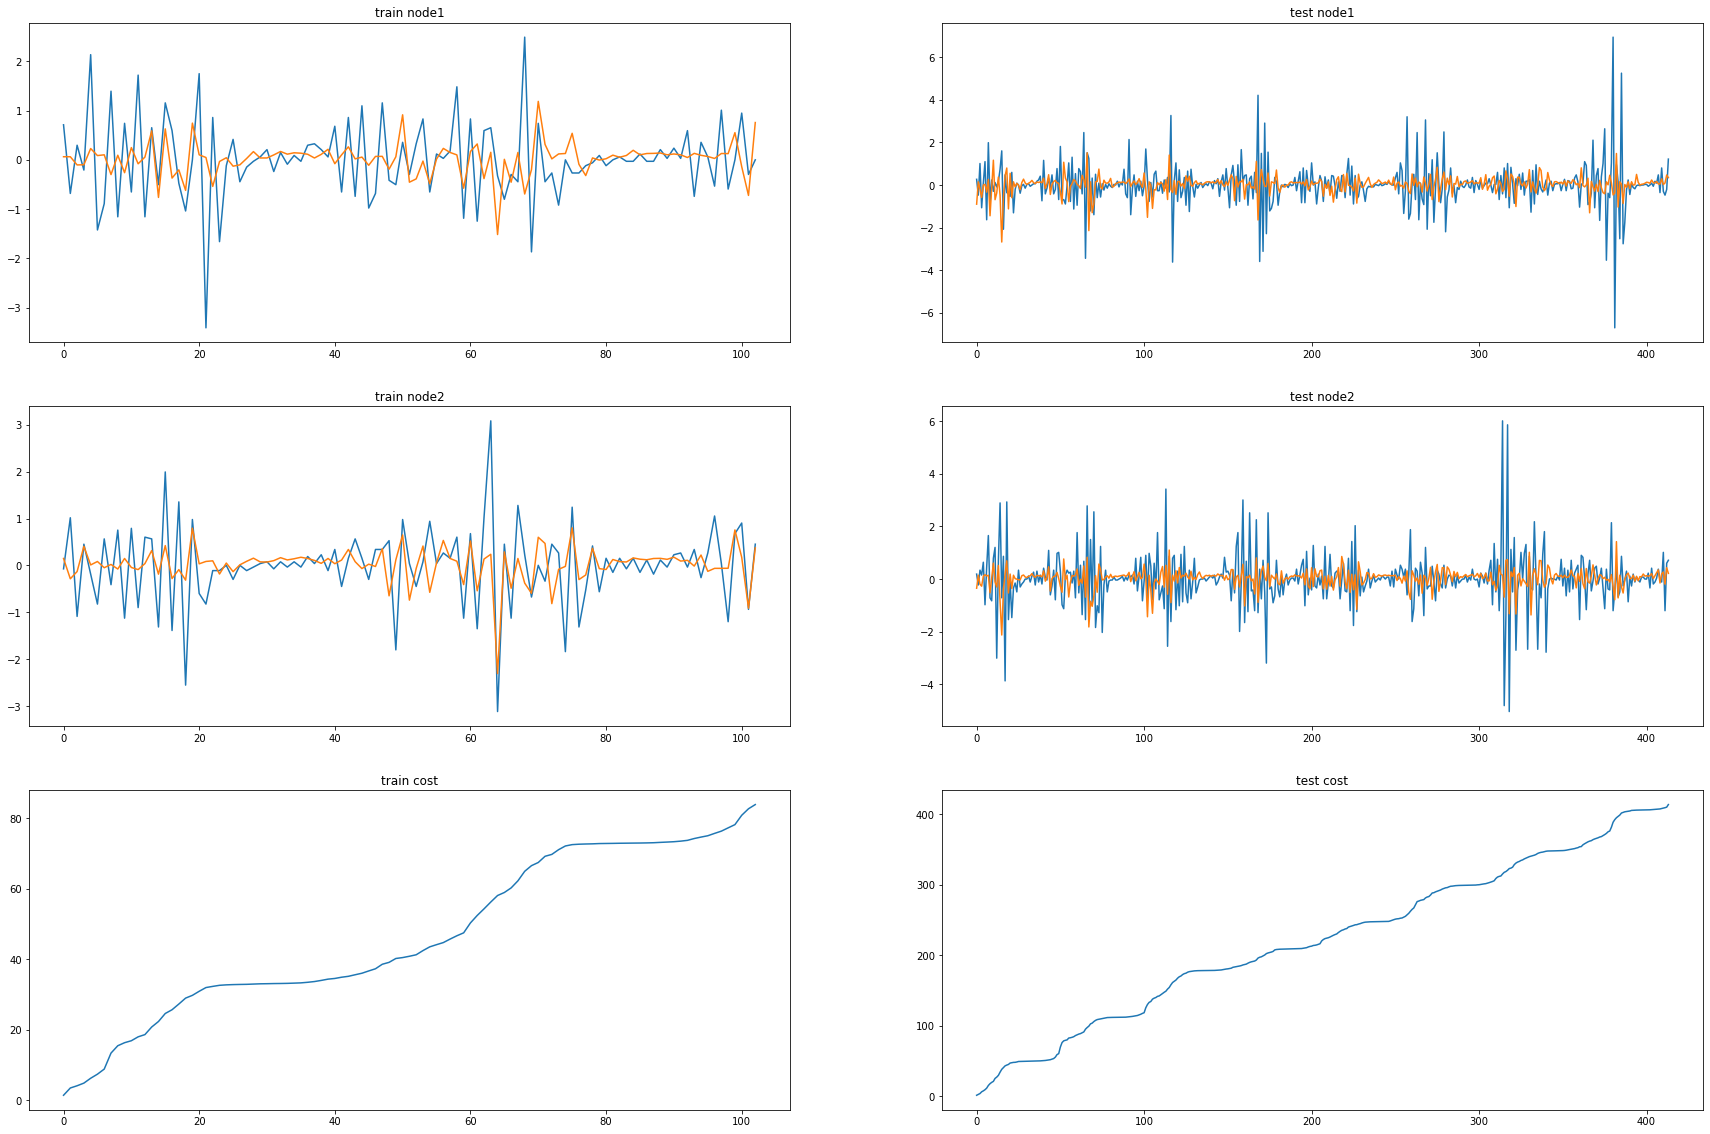

In [76]:
fig, (( ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(30,20))

ax1.set_title('train node1')
ax1.plot([train_dataset.targets[i][0] for i in range(train_dataset.snapshot_count)])
ax1.plot(torch.tensor([_b[i].detach()[0] for i in range(train_dataset.snapshot_count)]))

ax2.set_title('test node1')
ax2.plot([test_dataset.targets[i][0] for i in range(test_dataset.snapshot_count)])
ax2.plot(torch.tensor([_a[i].detach()[0] for i in range(test_dataset.snapshot_count)]))

ax3.set_title('train node2')
ax3.plot([train_dataset.targets[i][1] for i in range(train_dataset.snapshot_count)])
ax3.plot(torch.tensor([_b[i].detach()[1] for i in range(train_dataset.snapshot_count)]))


ax4.set_title('test node2')
ax4.plot([test_dataset.targets[i][1] for i in range(test_dataset.snapshot_count)])
ax4.plot(torch.tensor([_a[i].detach()[1] for i in range(test_dataset.snapshot_count)]))

ax5.set_title('train cost')
ax5.plot(_e)

ax6.set_title('test cost')
ax6.plot(_c)

# EVOLVEGCNO

In [145]:
EvolveGCNO?

Init signature:
EvolveGCNO(
    in_channels: int,
    improved: bool = False,
    cached: bool = False,
    normalize: bool = True,
    add_self_loops: bool = True,
)
Docstring:     
An implementation of the Evolving Graph Convolutional without Hidden Layer.
For details see this paper: `"EvolveGCN: Evolving Graph Convolutional
Networks for Dynamic Graph." <https://arxiv.org/abs/1902.10191>`_
Args:
    in_channels (int): Number of filters.
    improved (bool, optional): If set to :obj:`True`, the layer computes
        :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
        (default: :obj:`False`)
    cached (bool, optional): If set to :obj:`True`, the layer will cache
        the computation of :math:`\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2}` on first execution, and will use the
        cached version for further executions.
        This parameter should only be set to :obj:`True` in transductive
        learning scenarios. (default: :obj:`

In [78]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [79]:
# import torch
# import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import EvolveGCNO

# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)


In [80]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = EvolveGCNO(node_features)
        self.linear = torch.nn.Linear(node_features, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [81]:
model = RecurrentGCN(node_features = 4)
for param in model.parameters():
    param.retain_grad()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    _b=[]
    _d=[]
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
        _b.append(y_hat)
        _d.append(cost)
    cost = cost / (time+1)
    cost.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:08<00:00, 22.31it/s]


In [82]:
model.eval()
cost = 0
_a=[]
_a1=[]
for time, snapshot in enumerate(test_dataset):
    if time == 0:
        model.recurrent.weight = None
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
    _a1.append(cost)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.5661


In [83]:
_e = [_d[i].detach() for i in range(len(_d))]

In [84]:
_c = [_a1[i].detach() for i in range(len(_a1))]

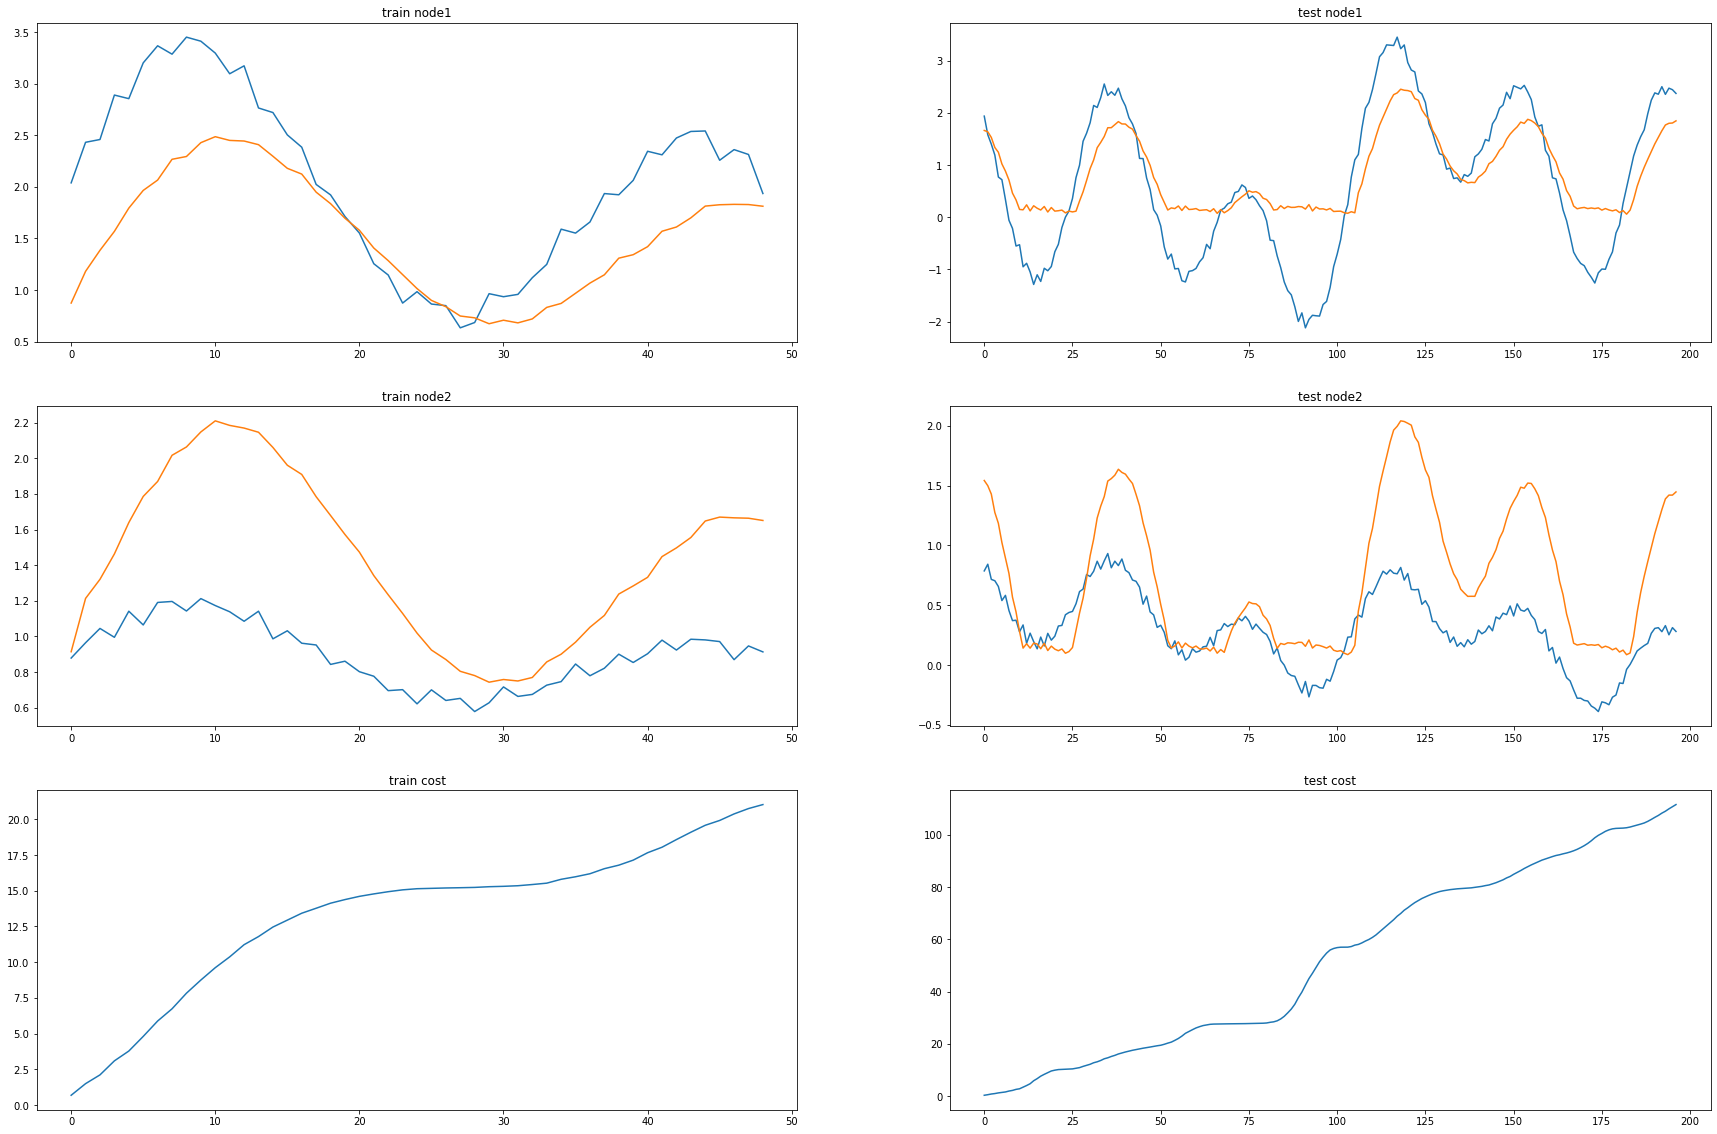

In [85]:
fig, (( ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(30,20))

ax1.set_title('train node1')
ax1.plot([train_dataset.targets[i][0] for i in range(train_dataset.snapshot_count)])
ax1.plot(torch.tensor([_b[i].detach()[0] for i in range(train_dataset.snapshot_count)]))

ax2.set_title('test node1')
ax2.plot([test_dataset.targets[i][0] for i in range(test_dataset.snapshot_count)])
ax2.plot(torch.tensor([_a[i].detach()[0] for i in range(test_dataset.snapshot_count)]))

ax3.set_title('train node2')
ax3.plot([train_dataset.targets[i][1] for i in range(train_dataset.snapshot_count)])
ax3.plot(torch.tensor([_b[i].detach()[1] for i in range(train_dataset.snapshot_count)]))


ax4.set_title('test node2')
ax4.plot([test_dataset.targets[i][1] for i in range(test_dataset.snapshot_count)])
ax4.plot(torch.tensor([_a[i].detach()[1] for i in range(test_dataset.snapshot_count)]))

ax5.set_title('train cost')
ax5.plot(_e)

ax6.set_title('test cost')
ax6.plot(_c)

# GCLSTM

In [146]:
GCLSTM?

Init signature:
GCLSTM(
    in_channels: int,
    out_channels: int,
    K: int,
    normalization: str = 'sym',
    bias: bool = True,
)
Docstring:     
An implementation of the the Integrated Graph Convolutional Long Short Term
Memory Cell. For details see this paper: `"GC-LSTM: Graph Convolution Embedded LSTM
for Dynamic Link Prediction." <https://arxiv.org/abs/1812.04206>`_

Args:
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    K (int): Chebyshev filter size :math:`K`.
    normalization (str, optional): The normalization scheme for the graph
        Laplacian (default: :obj:`"sym"`):

        1. :obj:`None`: No normalization
        :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

        2. :obj:`"sym"`: Symmetric normalization
        :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
        \mathbf{D}^{-1/2}`

        3. :obj:`"rw"`: Random-walk normalization
        :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1}

In [87]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [88]:
# import torch
# import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GCLSTM

# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [89]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GCLSTM(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [90]:
model = RecurrentGCN(node_features=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(100)): #200
    cost = 0
    h, c = None, None
    _b=[]
    _d=[]
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
        _b.append(y_hat)
        _d.append(cost)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 100/100 [00:10<00:00,  9.78it/s]


In [91]:
model.eval()
cost = 0
_a=[]
_a1=[]
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    y_hat.reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
    _a1.append(cost)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.8232


In [92]:
_e = [_d[i].detach() for i in range(len(_d))]

In [93]:
_c = [_a1[i].detach() for i in range(len(_a1))]

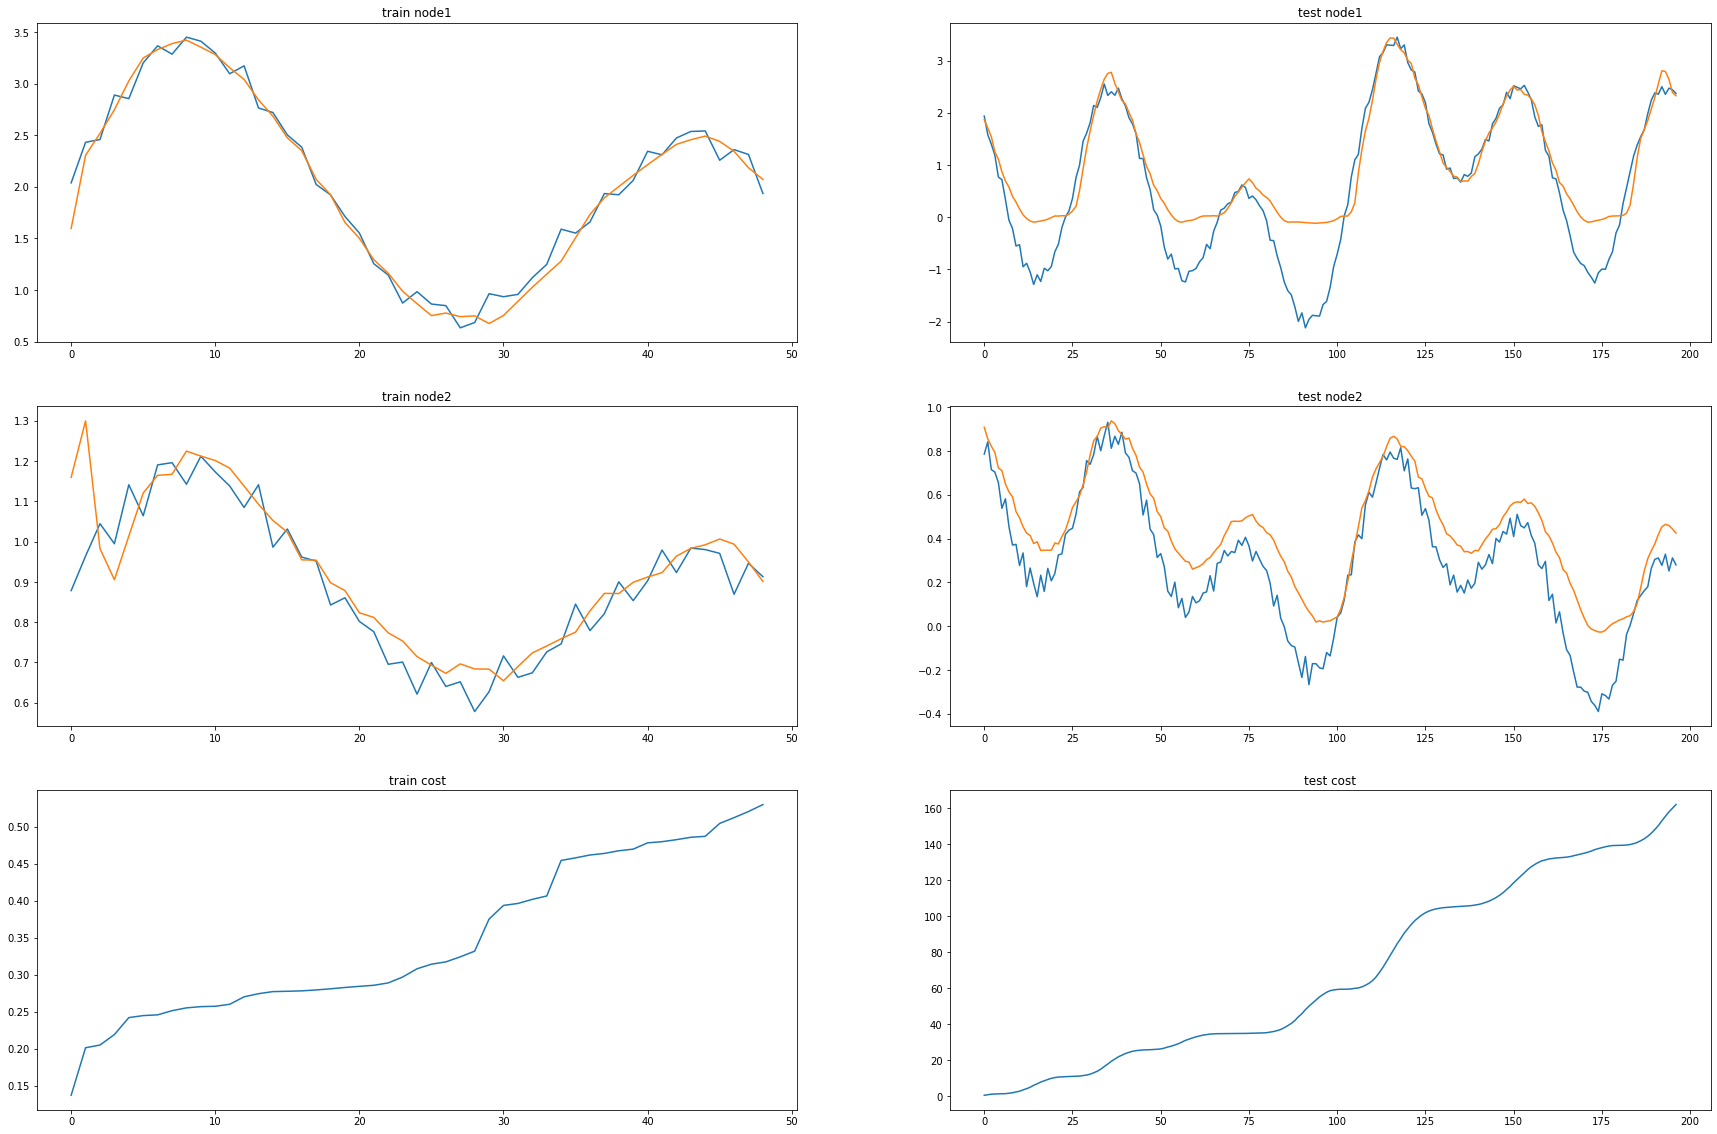

In [94]:
fig, (( ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(30,20))

ax1.set_title('train node1')
ax1.plot([train_dataset.targets[i][0] for i in range(train_dataset.snapshot_count)])
ax1.plot(torch.tensor([_b[i].detach()[0] for i in range(train_dataset.snapshot_count)]))

ax2.set_title('test node1')
ax2.plot([test_dataset.targets[i][0] for i in range(test_dataset.snapshot_count)])
ax2.plot(torch.tensor([_a[i].detach()[0] for i in range(test_dataset.snapshot_count)]))

ax3.set_title('train node2')
ax3.plot([train_dataset.targets[i][1] for i in range(train_dataset.snapshot_count)])
ax3.plot(torch.tensor([_b[i].detach()[1] for i in range(train_dataset.snapshot_count)]))


ax4.set_title('test node2')
ax4.plot([test_dataset.targets[i][1] for i in range(test_dataset.snapshot_count)])
ax4.plot(torch.tensor([_a[i].detach()[1] for i in range(test_dataset.snapshot_count)]))

ax5.set_title('train cost')
ax5.plot(_e)

ax6.set_title('test cost')
ax6.plot(_c)

# GConvLSTM

In [148]:
GConvLSTM?

Init signature:
GConvLSTM(
    in_channels: int,
    out_channels: int,
    K: int,
    normalization: str = 'sym',
    bias: bool = True,
)
Docstring:     
An implementation of the Chebyshev Graph Convolutional Long Short Term Memory
Cell. For details see this paper: `"Structured Sequence Modeling with Graph
Convolutional Recurrent Networks." <https://arxiv.org/abs/1612.07659>`_

Args:
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    K (int): Chebyshev filter size :math:`K`.
    normalization (str, optional): The normalization scheme for the graph
        Laplacian (default: :obj:`"sym"`):

        1. :obj:`None`: No normalization
        :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

        2. :obj:`"sym"`: Symmetric normalization
        :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
        \mathbf{D}^{-1/2}`

        3. :obj:`"rw"`: Random-walk normalization
        :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-

In [96]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [97]:
# import torch
# import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvLSTM

# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [98]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvLSTM(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [99]:
model = RecurrentGCN(node_features=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)): #200
    cost = 0
    h, c = None, None
    _b = []
    _d=[]
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
        _b.append(y_hat)
        _d.append(cost)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:46<00:00,  4.29it/s]


In [100]:
model.eval()
cost = 0
_a=[]
_a1=[]
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    y_hat = y_hat.reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
    _a1.append(cost)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.2613


In [101]:
_e = [_d[i].detach() for i in range(len(_d))]

In [102]:
_c = [_a1[i].detach() for i in range(len(_a1))]

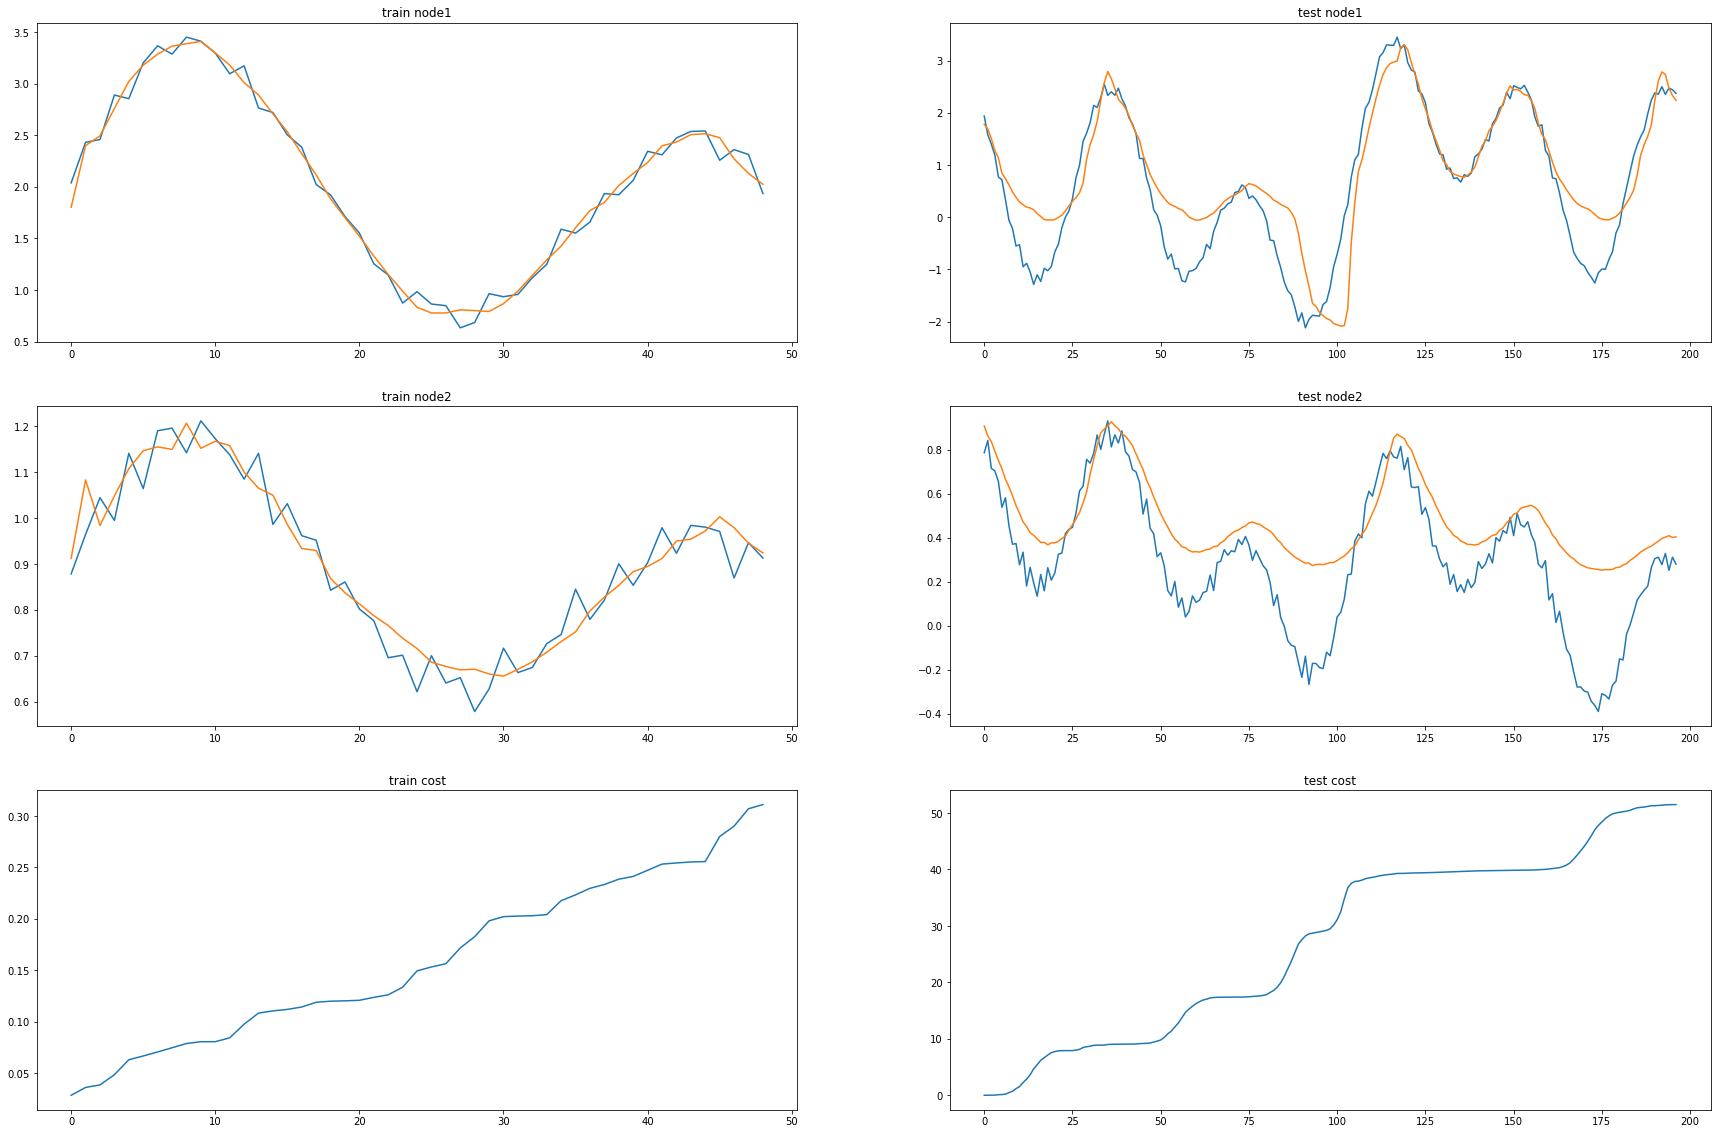

In [103]:
fig, (( ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(30,20))

ax1.set_title('train node1')
ax1.plot([train_dataset.targets[i][0] for i in range(train_dataset.snapshot_count)])
ax1.plot(torch.tensor([_b[i].detach()[0] for i in range(train_dataset.snapshot_count)]))

ax2.set_title('test node1')
ax2.plot([test_dataset.targets[i][0] for i in range(test_dataset.snapshot_count)])
ax2.plot(torch.tensor([_a[i].detach()[0] for i in range(test_dataset.snapshot_count)]))

ax3.set_title('train node2')
ax3.plot([train_dataset.targets[i][1] for i in range(train_dataset.snapshot_count)])
ax3.plot(torch.tensor([_b[i].detach()[1] for i in range(train_dataset.snapshot_count)]))


ax4.set_title('test node2')
ax4.plot([test_dataset.targets[i][1] for i in range(test_dataset.snapshot_count)])
ax4.plot(torch.tensor([_a[i].detach()[1] for i in range(test_dataset.snapshot_count)]))

ax5.set_title('train cost')
ax5.plot(_e)

ax6.set_title('test cost')
ax6.plot(_c)

# Lightning(설치 안 됨)

In [104]:
# import torch
# from torch.nn import functional as F

# import pytorch_lightning as pl
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# from torch_geometric_temporal.nn.recurrent import DCRNN
# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
# from torch_geometric_temporal.signal import temporal_signal_split

In [105]:
# class LitDiffConvModel(pl.LightningModule):

#     def __init__(self, node_features, filters):
#         super().__init__()
#         self.recurrent = DCRNN(node_features, filters, 1)
#         self.linear = torch.nn.Linear(filters, 1)


#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
#         return optimizer

#     def training_step(self, train_batch, batch_idx):
#         x = train_batch.x
#         y = train_batch.y.view(-1, 1)
#         edge_index = train_batch.edge_index
#         h = self.recurrent(x, edge_index)
#         h = F.relu(h)
#         h = self.linear(h)
#         loss = F.mse_loss(h, y)
#         return loss

#     def validation_step(self, val_batch, batch_idx):
#         x = val_batch.x
#         y = val_batch.y.view(-1, 1)
#         edge_index = val_batch.edge_index
#         h = self.recurrent(x, edge_index)
#         h = F.relu(h)
#         h = self.linear(h)
#         loss = F.mse_loss(h, y)
#         metrics = {'val_loss': loss}
#         self.log_dict(metrics)
#         return metrics

In [106]:
# loader = ChickenpoxDatasetLoader()

# dataset_loader = loader.get_dataset(lags=32)

# train_loader, val_loader = temporal_signal_split(dataset_loader,
#                                                  train_ratio=0.2)

In [107]:
# model = LitDiffConvModel(node_features=32,
#                          filters=16)

In [108]:
# early_stop_callback = EarlyStopping(monitor='val_loss',
#                                     min_delta=0.00,
#                                     patience=10,
#                                     verbose=False,
#                                     mode='max')

In [109]:
# trainer = pl.Trainer(callbacks=[early_stop_callback])

In [110]:
# trainer.fit(model, train_loader, val_loader)

# LRGCN

In [147]:
LRGCN?

Init signature:
LRGCN(
    in_channels: int,
    out_channels: int,
    num_relations: int,
    num_bases: int,
)
Docstring:     
An implementation of the Long Short Term Memory Relational
Graph Convolution Layer. For details see this paper: `"Predicting Path
Failure In Time-Evolving Graphs." <https://arxiv.org/abs/1905.03994>`_

Args:
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    num_relations (int): Number of relations.
    num_bases (int): Number of bases.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torch_geometric_temporal/nn/recurrent/lrgcn.py
Type:           type
Subclasses:     


In [112]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [113]:
# import torch
# import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import LRGCN

# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [114]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = LRGCN(node_features, 32, 1, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [115]:
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    h, c = None, None
    _b=[]
    _d=[]
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
        _b.append(y_hat)
        _d.append(cost)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:47<00:00,  4.23it/s]


In [116]:
model.eval()
cost = 0
h, c = None, None
_a=[]
_a1=[]
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    y_hat = y_hat.reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
    _a1.append(cost)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.2608


In [117]:
_e = [_d[i].detach() for i in range(len(_d))]

In [118]:
_c = [_a1[i].detach() for i in range(len(_a1))]

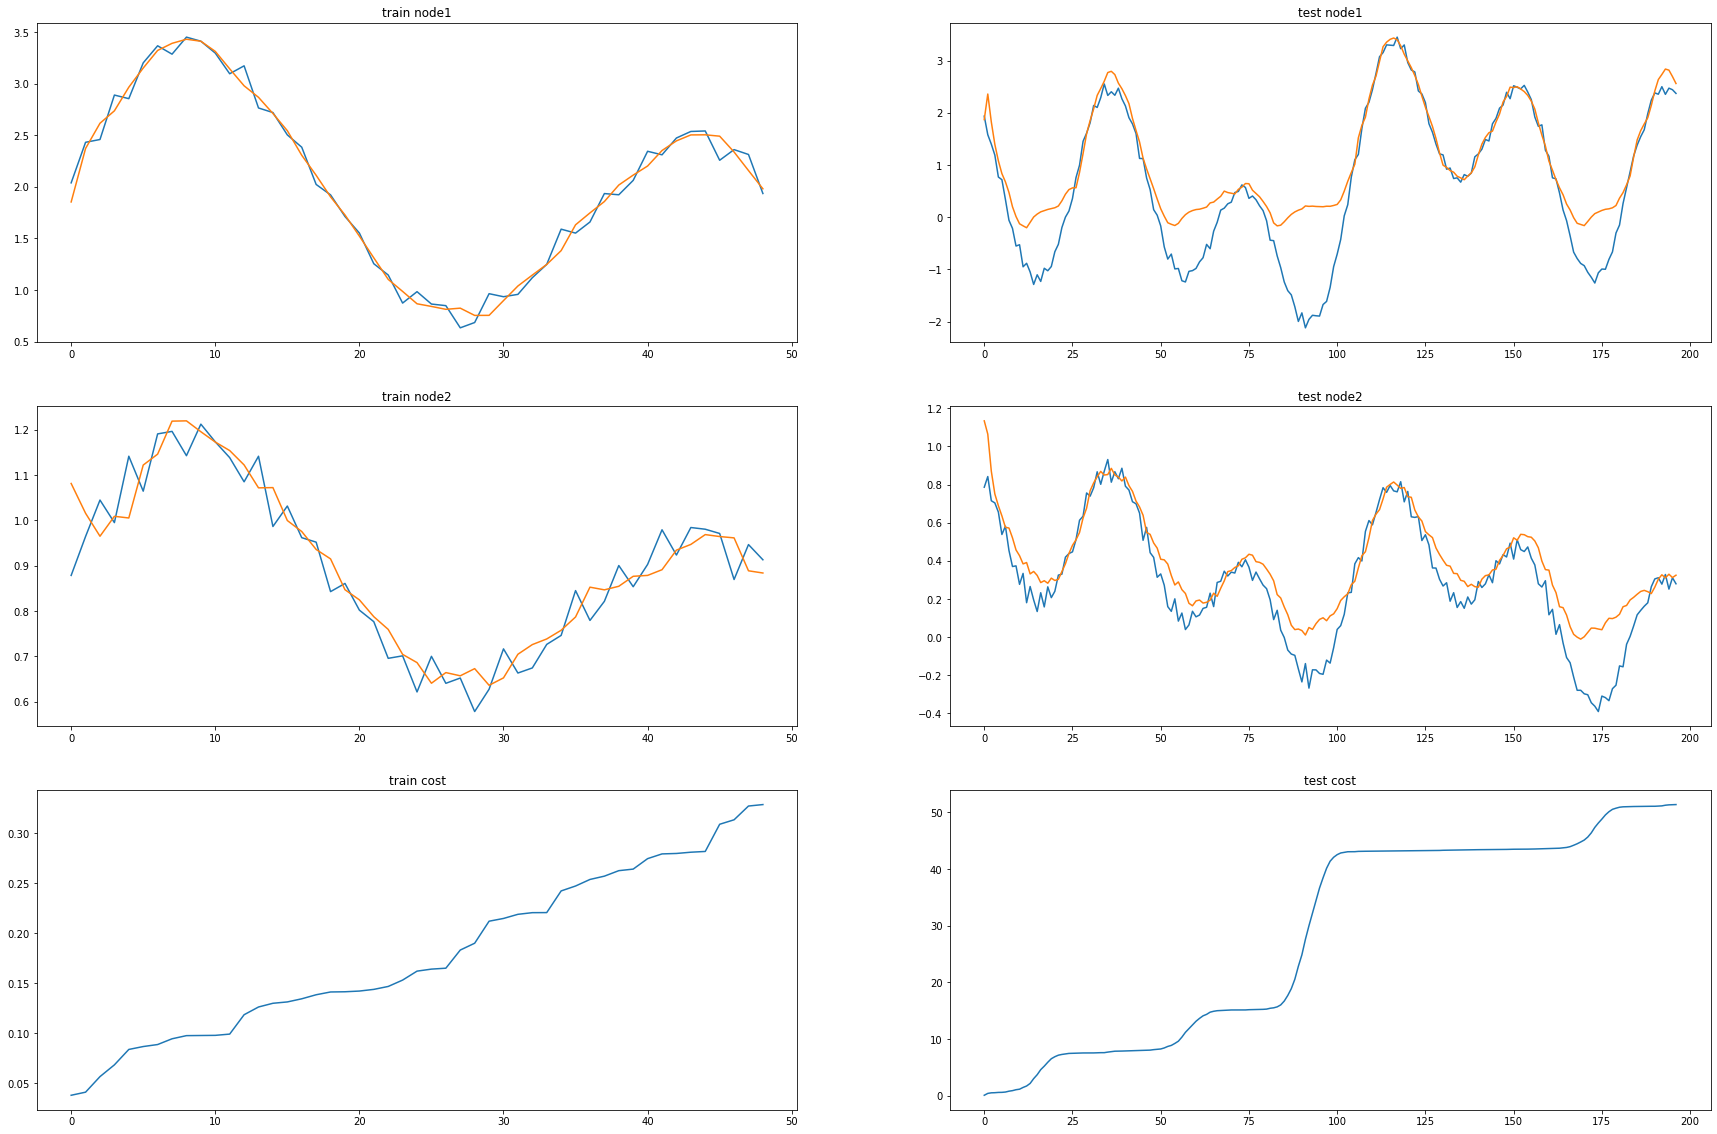

In [119]:
fig, (( ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(30,20))

ax1.set_title('train node1')
ax1.plot([train_dataset.targets[i][0] for i in range(train_dataset.snapshot_count)])
ax1.plot(torch.tensor([_b[i].detach()[0] for i in range(train_dataset.snapshot_count)]))

ax2.set_title('test node1')
ax2.plot([test_dataset.targets[i][0] for i in range(test_dataset.snapshot_count)])
ax2.plot(torch.tensor([_a[i].detach()[0] for i in range(test_dataset.snapshot_count)]))

ax3.set_title('train node2')
ax3.plot([train_dataset.targets[i][1] for i in range(train_dataset.snapshot_count)])
ax3.plot(torch.tensor([_b[i].detach()[1] for i in range(train_dataset.snapshot_count)]))


ax4.set_title('test node2')
ax4.plot([test_dataset.targets[i][1] for i in range(test_dataset.snapshot_count)])
ax4.plot(torch.tensor([_a[i].detach()[1] for i in range(test_dataset.snapshot_count)]))

ax5.set_title('train cost')
ax5.plot(_e)

ax6.set_title('test cost')
ax6.plot(_c)

# MPNNLSTM

In [149]:
MPNNLSTM?

Init signature:
MPNNLSTM(
    in_channels: int,
    hidden_size: int,
    num_nodes: int,
    window: int,
    dropout: float,
)
Docstring:     
An implementation of the Message Passing Neural Network with Long Short Term Memory.
For details see this paper: `"Transfer Graph Neural Networks for Pandemic Forecasting." <https://arxiv.org/abs/2009.08388>`_

Args:
    in_channels (int): Number of input features.
    hidden_size (int): Dimension of hidden representations.
    num_nodes (int): Number of nodes in the network.
    window (int): Number of past samples included in the input.
    dropout (float): Dropout rate.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torch_geometric_temporal/nn/recurrent/mpnn_lstm.py
Type:           type
Subclasses:     


In [121]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [122]:
# import torch
# import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import MPNNLSTM

# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [123]:
num_nodes=2

In [124]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = MPNNLSTM(node_features, 8,  num_nodes, 1, 0.3) # 32, 32, 20, 1, 0.5 이었는데 position 잘못되었다해서 32하나 뺌
        self.linear = torch.nn.Linear(num_nodes*8 + node_features, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [125]:
model = RecurrentGCN(node_features = 4)

In [126]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    cost = 0
    _b=[]
    _d=[]
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
        _b.append(y_hat)
        _d.append(cost)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]


In [127]:
model.eval()
cost = 0
_a=[]
_a1=[]
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
    _a1.append(cost)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.7127


In [128]:
_e = [_d[i].detach() for i in range(len(_d))]

In [129]:
_c = [_a1[i].detach() for i in range(len(_a1))]

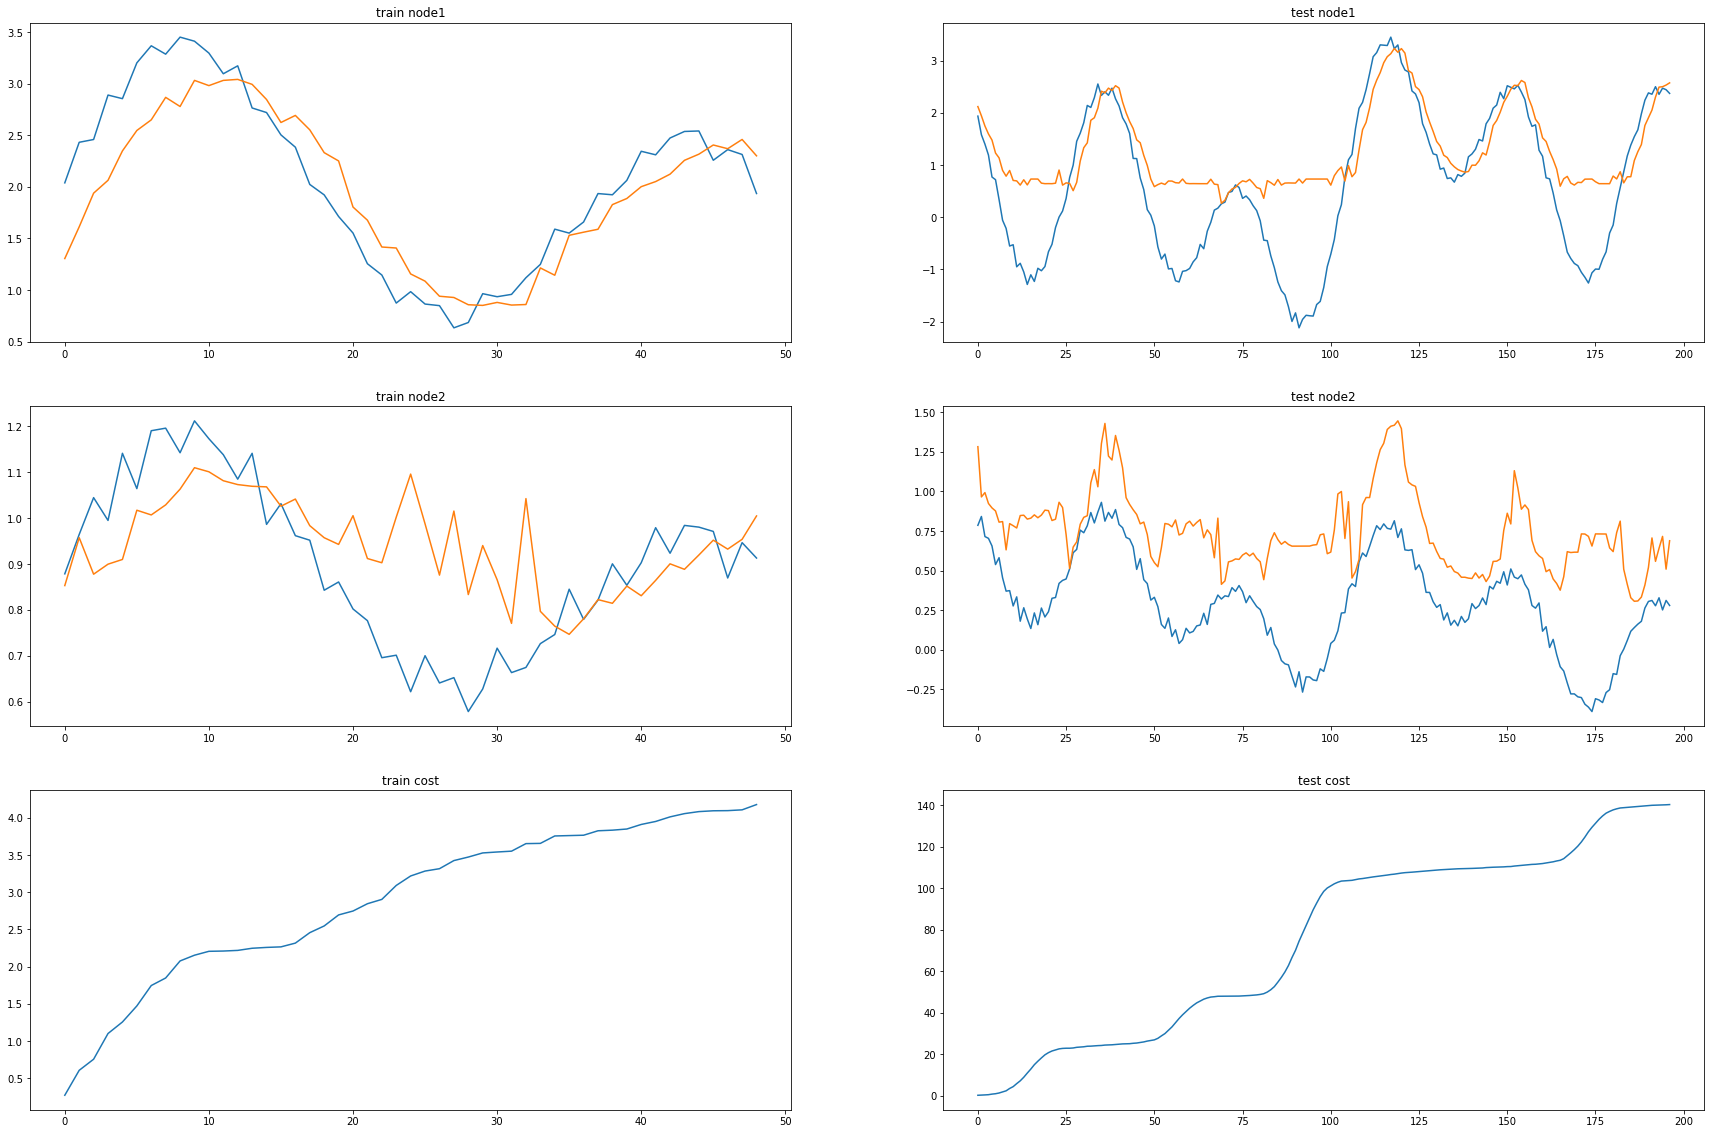

In [130]:
fig, (( ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(30,20))

ax1.set_title('train node1')
ax1.plot([train_dataset.targets[i][0] for i in range(train_dataset.snapshot_count)])
ax1.plot(torch.tensor([_b[i].detach()[0] for i in range(train_dataset.snapshot_count)]))

ax2.set_title('test node1')
ax2.plot([test_dataset.targets[i][0] for i in range(test_dataset.snapshot_count)])
ax2.plot(torch.tensor([_a[i].detach()[0] for i in range(test_dataset.snapshot_count)]))

ax3.set_title('train node2')
ax3.plot([train_dataset.targets[i][1] for i in range(train_dataset.snapshot_count)])
ax3.plot(torch.tensor([_b[i].detach()[1] for i in range(train_dataset.snapshot_count)]))


ax4.set_title('test node2')
ax4.plot([test_dataset.targets[i][1] for i in range(test_dataset.snapshot_count)])
ax4.plot(torch.tensor([_a[i].detach()[1] for i in range(test_dataset.snapshot_count)]))

ax5.set_title('train cost')
ax5.plot(_e)

ax6.set_title('test cost')
ax6.plot(_c)

# TGCN

In [150]:
TGCN?

Init signature:
TGCN(
    in_channels: int,
    out_channels: int,
    improved: bool = False,
    cached: bool = False,
    add_self_loops: bool = True,
)
Docstring:     
An implementation of the Temporal Graph Convolutional Gated Recurrent Cell.
For details see this paper: `"T-GCN: A Temporal Graph ConvolutionalNetwork for
Traffic Prediction." <https://arxiv.org/abs/1811.05320>`_

Args:
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    improved (bool): Stronger self loops. Default is False.
    cached (bool): Caching the message weights. Default is False.
    add_self_loops (bool): Adding self-loops for smoothing. Default is True.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torch_geometric_temporal/nn/recurrent/temporalgcn.py
Type:           type
Subclasses:     


In [132]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [133]:
# import torch
# import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import TGCN

# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [134]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = TGCN(node_features, 16)
        self.linear = torch.nn.Linear(16, 1)

    def forward(self, x, edge_index, edge_weight, prev_hidden_state):
        h = self.recurrent(x, edge_index, edge_weight, prev_hidden_state)
        y = F.relu(h)
        y = self.linear(y)
        return y, h

In [135]:
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    cost = 0
    hidden_state = None
    _b=[]
    _d=[]
    for time, snapshot in enumerate(train_dataset):
        y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr,hidden_state)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
        _b.append(y_hat)
        _d.append(cost)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


In [136]:
model.eval()
cost = 0
hidden_state = None
_a=[]
_a1=[]
for time, snapshot in enumerate(test_dataset):
    y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, hidden_state)
    y_hat = y_hat.reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
    _a1.append(cost)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.8557


In [137]:
_e = [_d[i].detach() for i in range(len(_d))]

In [138]:
_c = [_a1[i].detach() for i in range(len(_a1))]

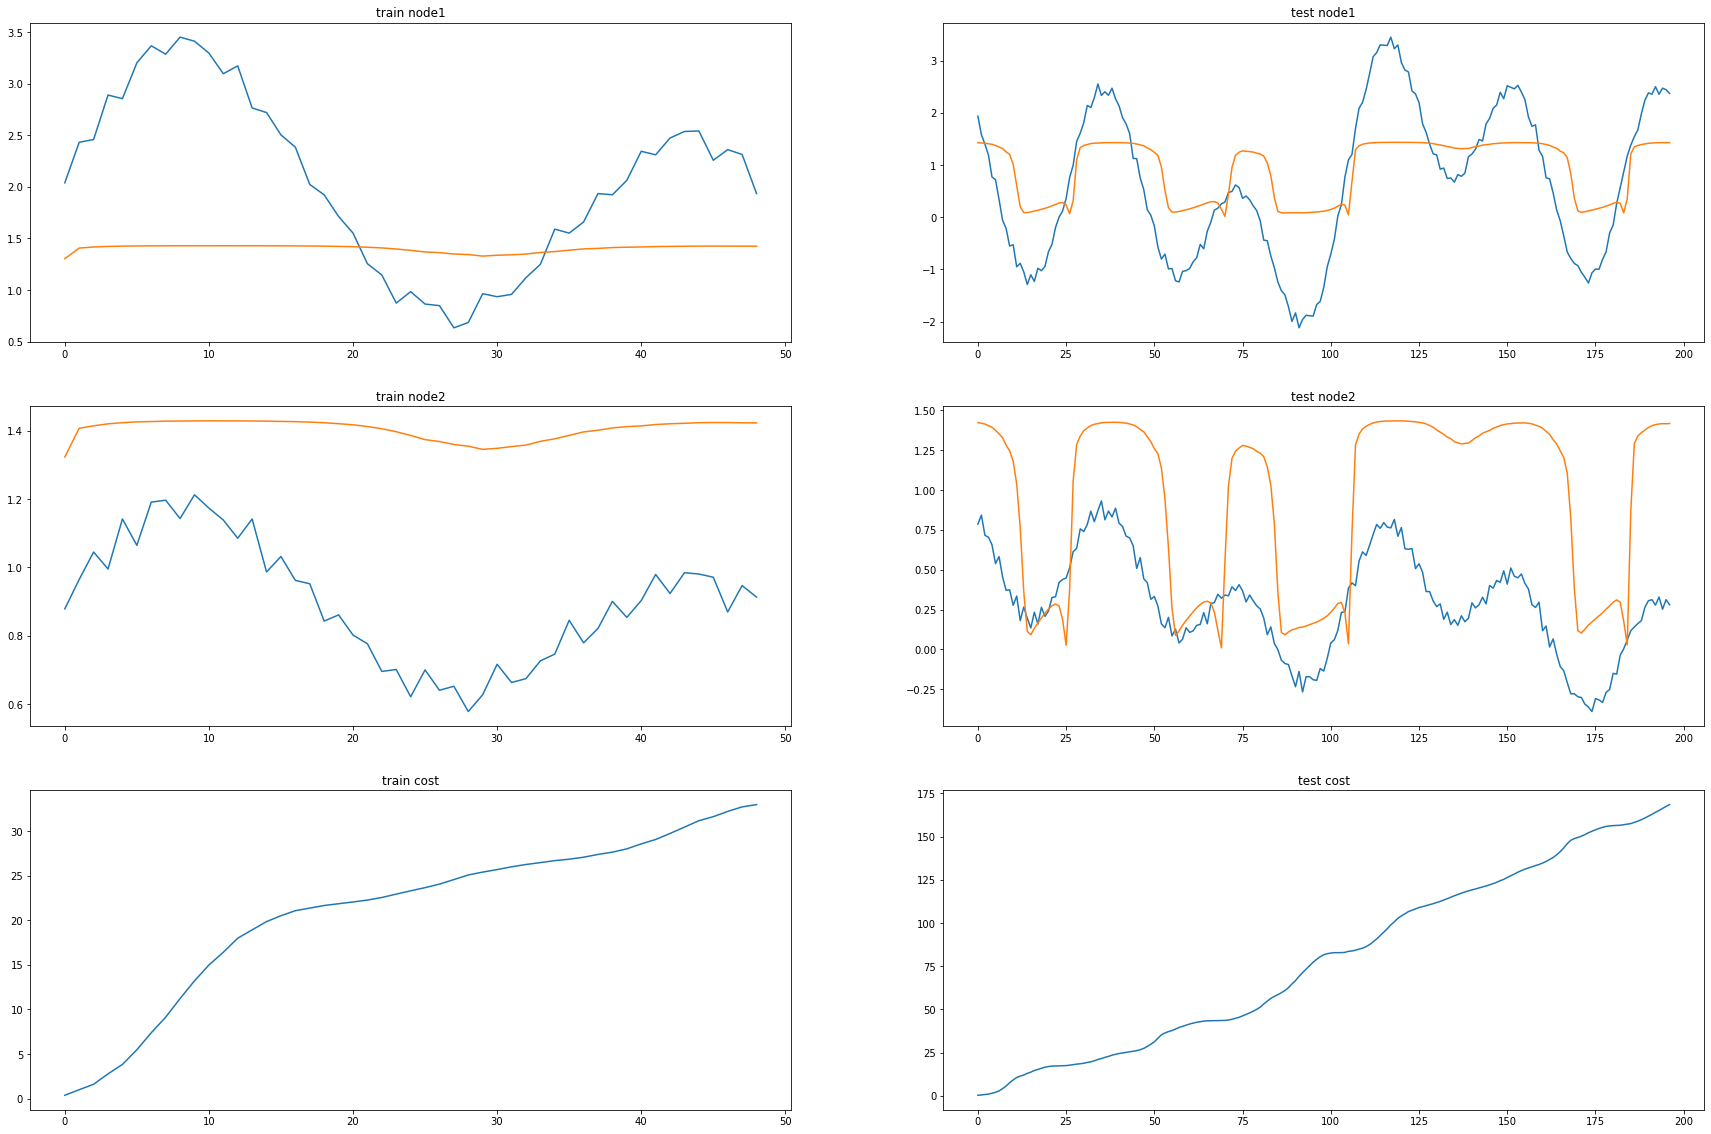

In [139]:
fig, (( ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(30,20))

ax1.set_title('train node1')
ax1.plot([train_dataset.targets[i][0] for i in range(train_dataset.snapshot_count)])
ax1.plot(torch.tensor([_b[i].detach()[0] for i in range(train_dataset.snapshot_count)]))

ax2.set_title('test node1')
ax2.plot([test_dataset.targets[i][0] for i in range(test_dataset.snapshot_count)])
ax2.plot(torch.tensor([_a[i].detach()[0] for i in range(test_dataset.snapshot_count)]))

ax3.set_title('train node2')
ax3.plot([train_dataset.targets[i][1] for i in range(train_dataset.snapshot_count)])
ax3.plot(torch.tensor([_b[i].detach()[1] for i in range(train_dataset.snapshot_count)]))


ax4.set_title('test node2')
ax4.plot([test_dataset.targets[i][1] for i in range(test_dataset.snapshot_count)])
ax4.plot(torch.tensor([_a[i].detach()[1] for i in range(test_dataset.snapshot_count)]))

ax5.set_title('train cost')
ax5.plot(_e)

ax6.set_title('test cost')
ax6.plot(_c)